## Final Project Submission

Please fill out:
* Student name: Aaron Bastian
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Introduction
The purpose of this project was to discover which types of films are currently performing "the best" at the box office in order to inform a company attempting to enter into the film industry. For the purposes of this notebook, I took "the best" to mean those which are the most profitable, and thus made my deductions based on metrics of **net profit** and **Return on investment (ROI)**. I utilized the *TMDB 5000 Movie Dataset* available on [kaggle](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata). This is an ideal database as it contains current information on a vast number of relavant films.

I compared films in the database based upon the correlations between their afformentioned metrics and runtime, genre, actors, writers, and directors.

In [2]:
from matplotlib import pyplot as plt  # Visualisation
import scipy.stats as stats  # statistical correlations
import pandas as pd  # Data analysis and manipulation
import numpy as np  # Purely for access to the np.nan data type
import json  # For unpacking json type strings included in the TMDB 5000 dataset
import os # For file manipulation

I get the absolute path to the phase1project directory dynamically by transforming the local path to one directory above the current working directory.  Then I get the absolute path the the directory storing the data `.csv` files by joining the dir name to the base directory.

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, "TMDB_5000")

To ensure uniform styling of visualizations, I utlize matplotlib's stylesheets. I get the absolute path to the `.mplstyle` file I created, and set it as the default style via the `use()` method. I created one that uses a Microsoft like color scheme.

In [4]:
MP_STYLE = os.path.join(BASE_DIR, "style.mplstyle")
plt.style.use(MP_STYLE)

Here, I load each `.csv` file into a pandas `DataFrame` object and add them to a dictionary. The TMDB files were saved in such a way that the correct data types were inferred for each column without requiring the application of `pd.to_numeric` and/or other methods.

In [5]:
dfs = {}

for file_name in os.listdir(DATA_DIR):
    dfs[file_name.split(".")[0]] = pd.read_csv(os.path.join(DATA_DIR, file_name))

Here I join the two DataFrame objects. I use the `pd.merge` method instead of `pd.join` here as `pd.join` combines the dfs basedupon their indices only.  I then filter out the films that have yet to be, or never will be, released and those with budgets or revenues less than $1000. $1000 was somewhat arbitrarily selected to filter out entries where either
1. **These values were 0** (likely an NaN placeholder to preserve the numeric d-type)
2. **These values were very small** (I noticed some < 1000 and assumed they might have meant to represent millions, but they were few enough that removing them was simpler than blindly assuming that were true.)

In [6]:
joined_df = dfs.get("tmdb_5000_credits").rename(columns={"movie_id":"id"}).merge(dfs.get("tmdb_5000_movies").drop(columns=["title"]), on="id")
joined_df = joined_df[joined_df.status == "Released"]
joined_df = joined_df[joined_df.budget > 1000]
joined_df = joined_df[joined_df.revenue > 1000]

To keep things clean, I create a new `DataFrame` "df" with all the columns I will need for my analysis. I then create `net_profit`[1] and `ROI`[2] columns using simple numpy element-wise operations.

1. Net Profit = Revenue - Cost
2. Return on Investestment = (Revenue - Cost) / Cost

In [7]:
df = joined_df[["id", "title", "budget", "revenue", "genres", "runtime", "cast", "crew"]]
df["net_profit"] = df.revenue - df.budget
df["ROI"] = df.net_profit / df.budget

/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_10885/2853587483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["net_profit"] = df.revenue - df.budget
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_10885/2853587483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ROI"] = df.net_profit / df.budget


## Correlations
First I created this simple function to remove outliers from a data frame. This allows for better looking graphs.

In [8]:
def remove_outliers(df:pd.DataFrame, columns:list) -> pd.DataFrame:
    new_df = df

    for column in columns:
        col = new_df[column]
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR = Q3 - Q1

        new_df = new_df[new_df[column] < Q3 + 1.5 * IQR]
        new_df = new_df[new_df[column] > Q1 - 1.5 * IQR]

    return new_df   

To do the correlations, I first make a 2D list of column names I would like to correlate together. I do something similar in a different way later on. I create a `figure` object with 4 axes objects using the `plt.subplots` method. Inside the for loop, I create a scatter plot for each correlation, then calculate the actual linear regression (using Scipy) and add the result as an annotation. To plot the regression line, I use `np.polyfit` to find the slope (m) and y-intercept (b) of the data and plot using the `axline` method. 

I found the np.polyfit method on [this blog](https://www.statology.org/scatterplot-with-regression-line-python/).  I tried doing this manually, but was having issues due to the differences in scale of the x and y axes.

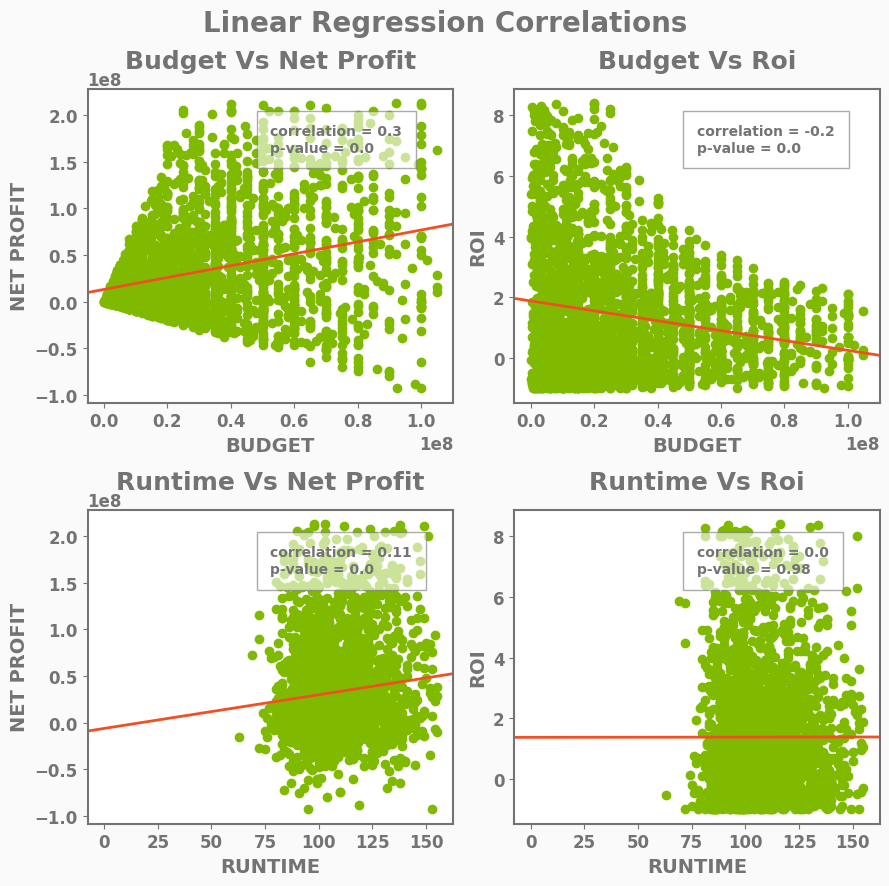

In [9]:
corrs = [["budget", "net_profit"], ["budget", "ROI"], ["runtime", "net_profit"], ["runtime", "ROI"]]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize = (9,9), dpi=100)
fig.tight_layout()
fig.suptitle("Linear Regression Correlations")

out_df = remove_outliers(df, ["ROI", "net_profit", "runtime", "budget"])

for idx, corr in enumerate(corrs):
    x = out_df[corr[0]]
    y = out_df[corr[1]]

    ax = axes[idx//2][idx%2]
    ax.set_title(" vs ".join(corr).replace("_", " ").title(), pad=15)
    points = ax.scatter(x, y)
    ax.set_xlabel(corr[0].upper())
    ax.set_ylabel(corr[1].replace("_", " ").upper())
    ax.grid(False)

    stat = stats.linregress(x, y)
    ax.axline((0, stat.intercept), slope=stat.slope, color="#F25022", linewidth=2)

    text = "correlation = %s\np-value = %s" % (round(stat.rvalue, 2), round(stat.pvalue, 2))
    ax.text(0.5, 0.8, text, transform=ax.transAxes, bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 10})

## Creating Specific DataFrames

To analyze the genres, actors, writers, and directors, I will make separate, more concise DataFrames. To do this, I will first create the function `expand_column` which will create a new DataFrame given the old data frame and column name to be expanded. each "condensed" column value is a string of a list of dictionaries; each dictionary corresponding to the data of one person.

`expand_column` first makes a copy of the provided DataFrame to edit. It then applys the `json.loads` function. This converts the string values to list values. Then, the `pd.DataFrame.explode` method is used to create a new row for each value (dict) of the array with the other column values being duplicated for each new row.  That way, the movie info matches each element of the array.

In [10]:
def expand_column(df:pd.DataFrame, column:str) -> pd.DataFrame:
    new_df = df.copy()
    new_df[column] = new_df[column].apply(json.loads)
    return new_df.explode(column, ignore_index=True).dropna(subset=column)

Creating the `genres_df`, `actors_df`, and `crew_df` are done in much the same way. I first generate the expanded DataFrame using the `expand_column` function on a simplified version of "df" and the respective column of interest. I then convert the column to string names by applying a lambda that simply gets the "name" key/value from the dict value. Finally, I remove the outliers.

In [11]:
# MAKE GENRES_DF
genres_df = expand_column(df.drop(columns=["cast", "crew"]), "genres")
genres_df.genres = genres_df.genres.apply(lambda x: x.get("name"))
genres_df = remove_outliers(genres_df, columns=["net_profit", "ROI"])

The only difference in the `actors_df` is that I only include actors that have been in more than 5 films.  I do this because it would be dificult to draw any conclusions about their effect on a new film given such a small history.  To do this, I get the `value_counts()` of the actors column, and then get the index (names) that have values > 5.  Five was another relatively arbitrary number, but I found that this prevented the issue of irrelevant actors from successful movies popping up. For example, an extra in the Harry Potter series may appear to be extremely valuable.

In [12]:
# MAKE ACTORS_DF
actors_df = expand_column(df, "cast").drop(columns=["genres", "crew"]).rename(columns={"cast":"actors"})
actors_df.actors = actors_df.actors.apply(lambda x: x.get("name"))

known_actors = actors_df.actors.value_counts()
known_actors = known_actors.index[known_actors > 5]

actors_df = actors_df[actors_df.actors.isin(known_actors)]
actors_df = remove_outliers(actors_df, columns=["net_profit", "ROI"])

Making the `crew_df` (directors and writers) is slightly more complicated due to needing more than one value from each row, but uses the same basic princible. Rather than overwriting the column, I create two new columns, "job" and "name", by again applying a simple lambda. Then I just drop the expanded dict column "crew" 

In [13]:
# MAKE CREW_DF
crew_df = expand_column(df.drop(columns=["genres", "cast"]), "crew")

crew_df["job"] = crew_df.crew.apply(lambda x: x.get("job"))
crew_df["name"] = crew_df.crew.apply(lambda x: x.get("name"))
crew_df = crew_df.drop(columns=["crew"])

known = crew_df.name.value_counts()
known = known.index[known > 3]

crew_df = crew_df[crew_df.name.isin(known)]
crew_df = remove_outliers(crew_df, columns=["net_profit", "ROI"])

## Analyzing Specific DataFrames
### GENRE ANALYSIS
To find the most profitable genres, I grouped each genre by their mean net profit and ROI, sorted them by said markers, and took the top 10. I used mean rather than median as I had already filtered out outliers. I also create a dictionary of the top genre dataframes for use later.

For the actual graph, I used a bar plot utilizing my default style params. Getting the rotation for the genre names was slightly difficult as there are many ways to do this, but only a few methods allow you to also affect the allignment and anchor location of the labels. If you do not assign those variables, the labels will be rotated about the center of each label, and it will be confusing to see which label corresponds to which axis.

I also made a dictionary to store the tope genres for future use.


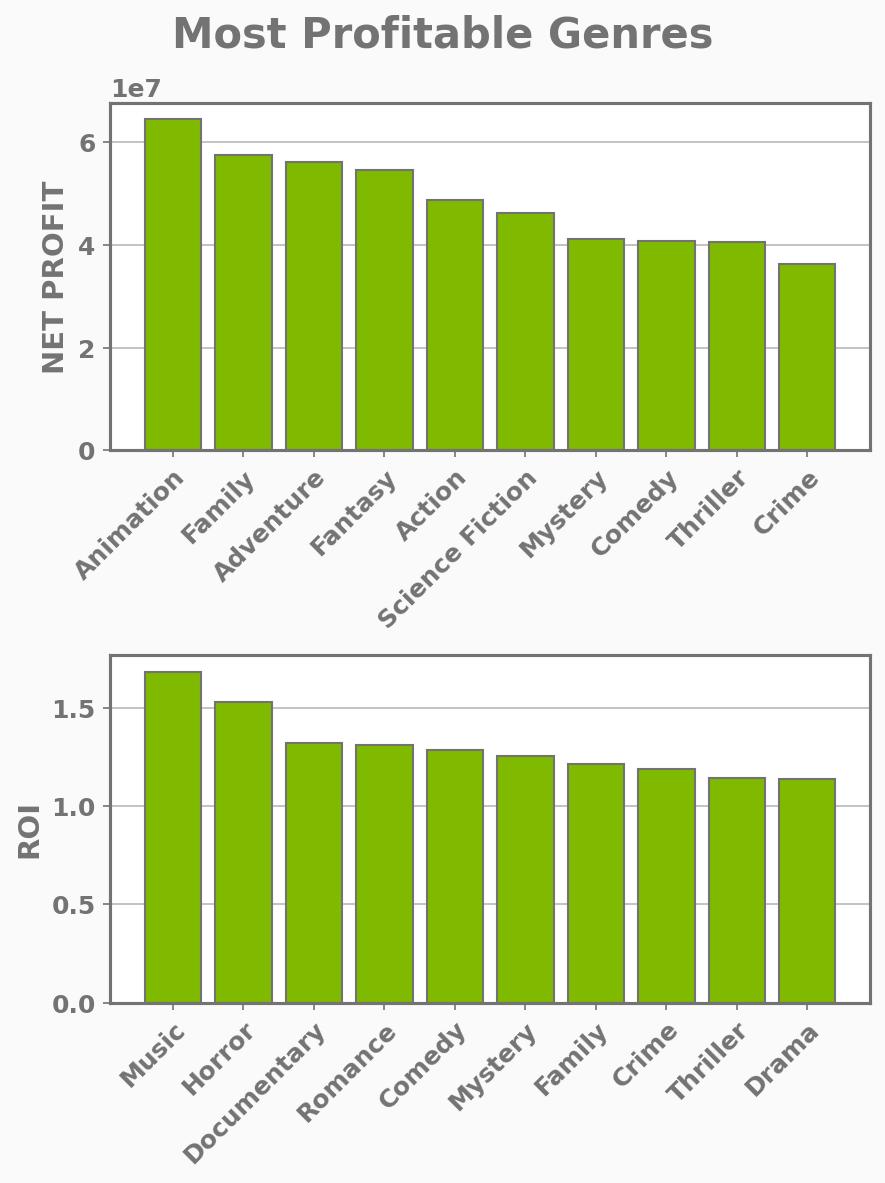

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=1, tight_layout=True, figsize=(6,8))
fig.suptitle("Most Profitable Genres")

top_genres = {}

for idx, marker in enumerate(["net_profit", "ROI"]):
    test = genres_df.groupby("genres").mean().sort_values(marker, ascending=False)[:10]
    top_genres[marker] = test.index
    ax = axs[idx]
    ax.bar(test.index, height=test[marker])
    ax.set_ylabel(marker.replace("_", " ").upper())
    ax.set_xticks(ax.get_xticks()) # this prevents a warning caused by the following line.
    ax.set_xticklabels(test.index, rotation=45, ha='right', rotation_mode='anchor')


### CAST / ACTORS ANALYSIS
Done exactly the same as genre analysis.

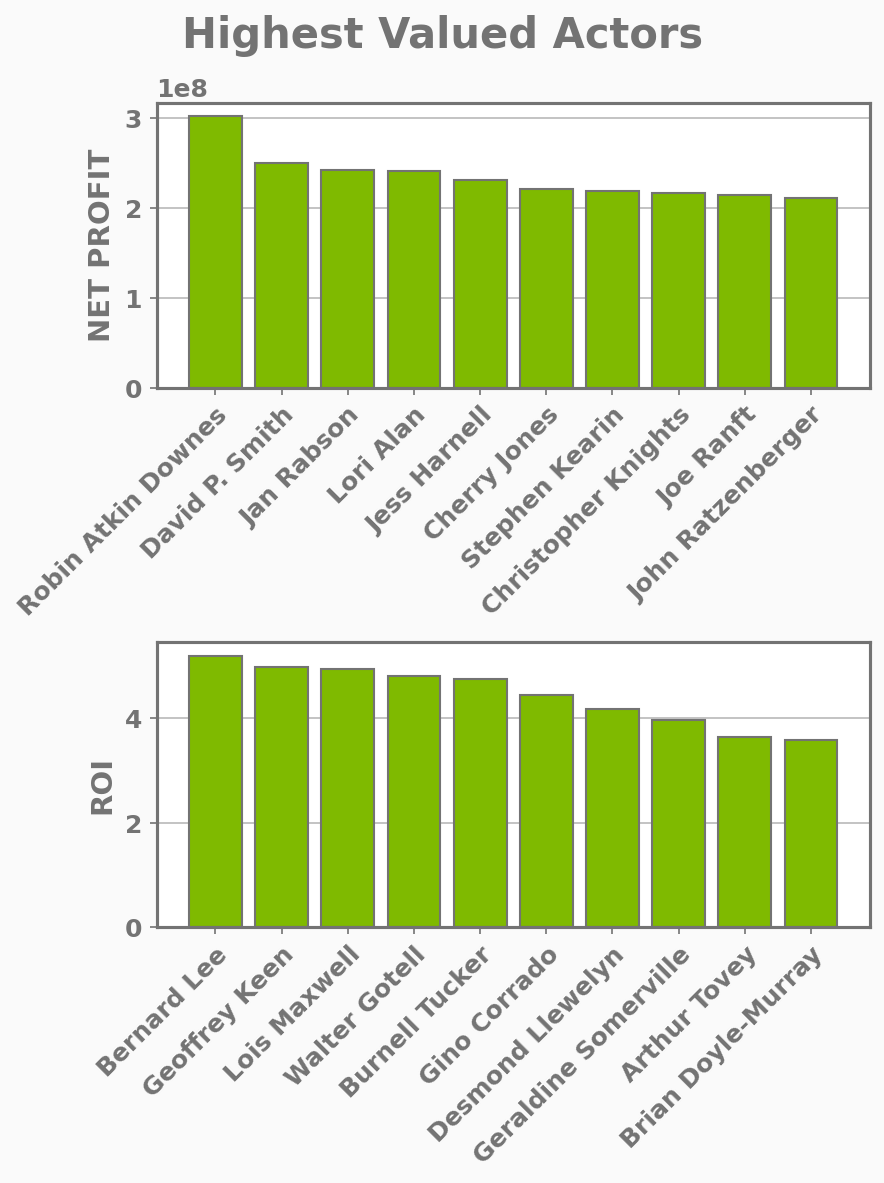

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=1, tight_layout=True, figsize=(6,8))
fig.suptitle("Highest Valued Actors")

for idx, marker in enumerate(["net_profit", "ROI"]):
    test = actors_df.groupby("actors").mean().sort_values(marker, ascending=False)[:10]#.drop_duplicates(subset=marker)

    ax = axs[idx]
    ax.bar(test.index, height=test[marker])
    ax.set_xticks(ax.get_xticks()) # this prevents a warning caused by the following line.
    ax.set_xticklabels(test.index, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylabel(marker.replace("_", " ").upper())

### DIRECTORS / WRITERS ANALYSIS
To analyze both directors and writers in the same loop, I created a 2x2 figure and enumerated the markers and jobs in order to access the correct axes. Otherwise, this is done the same as previously.

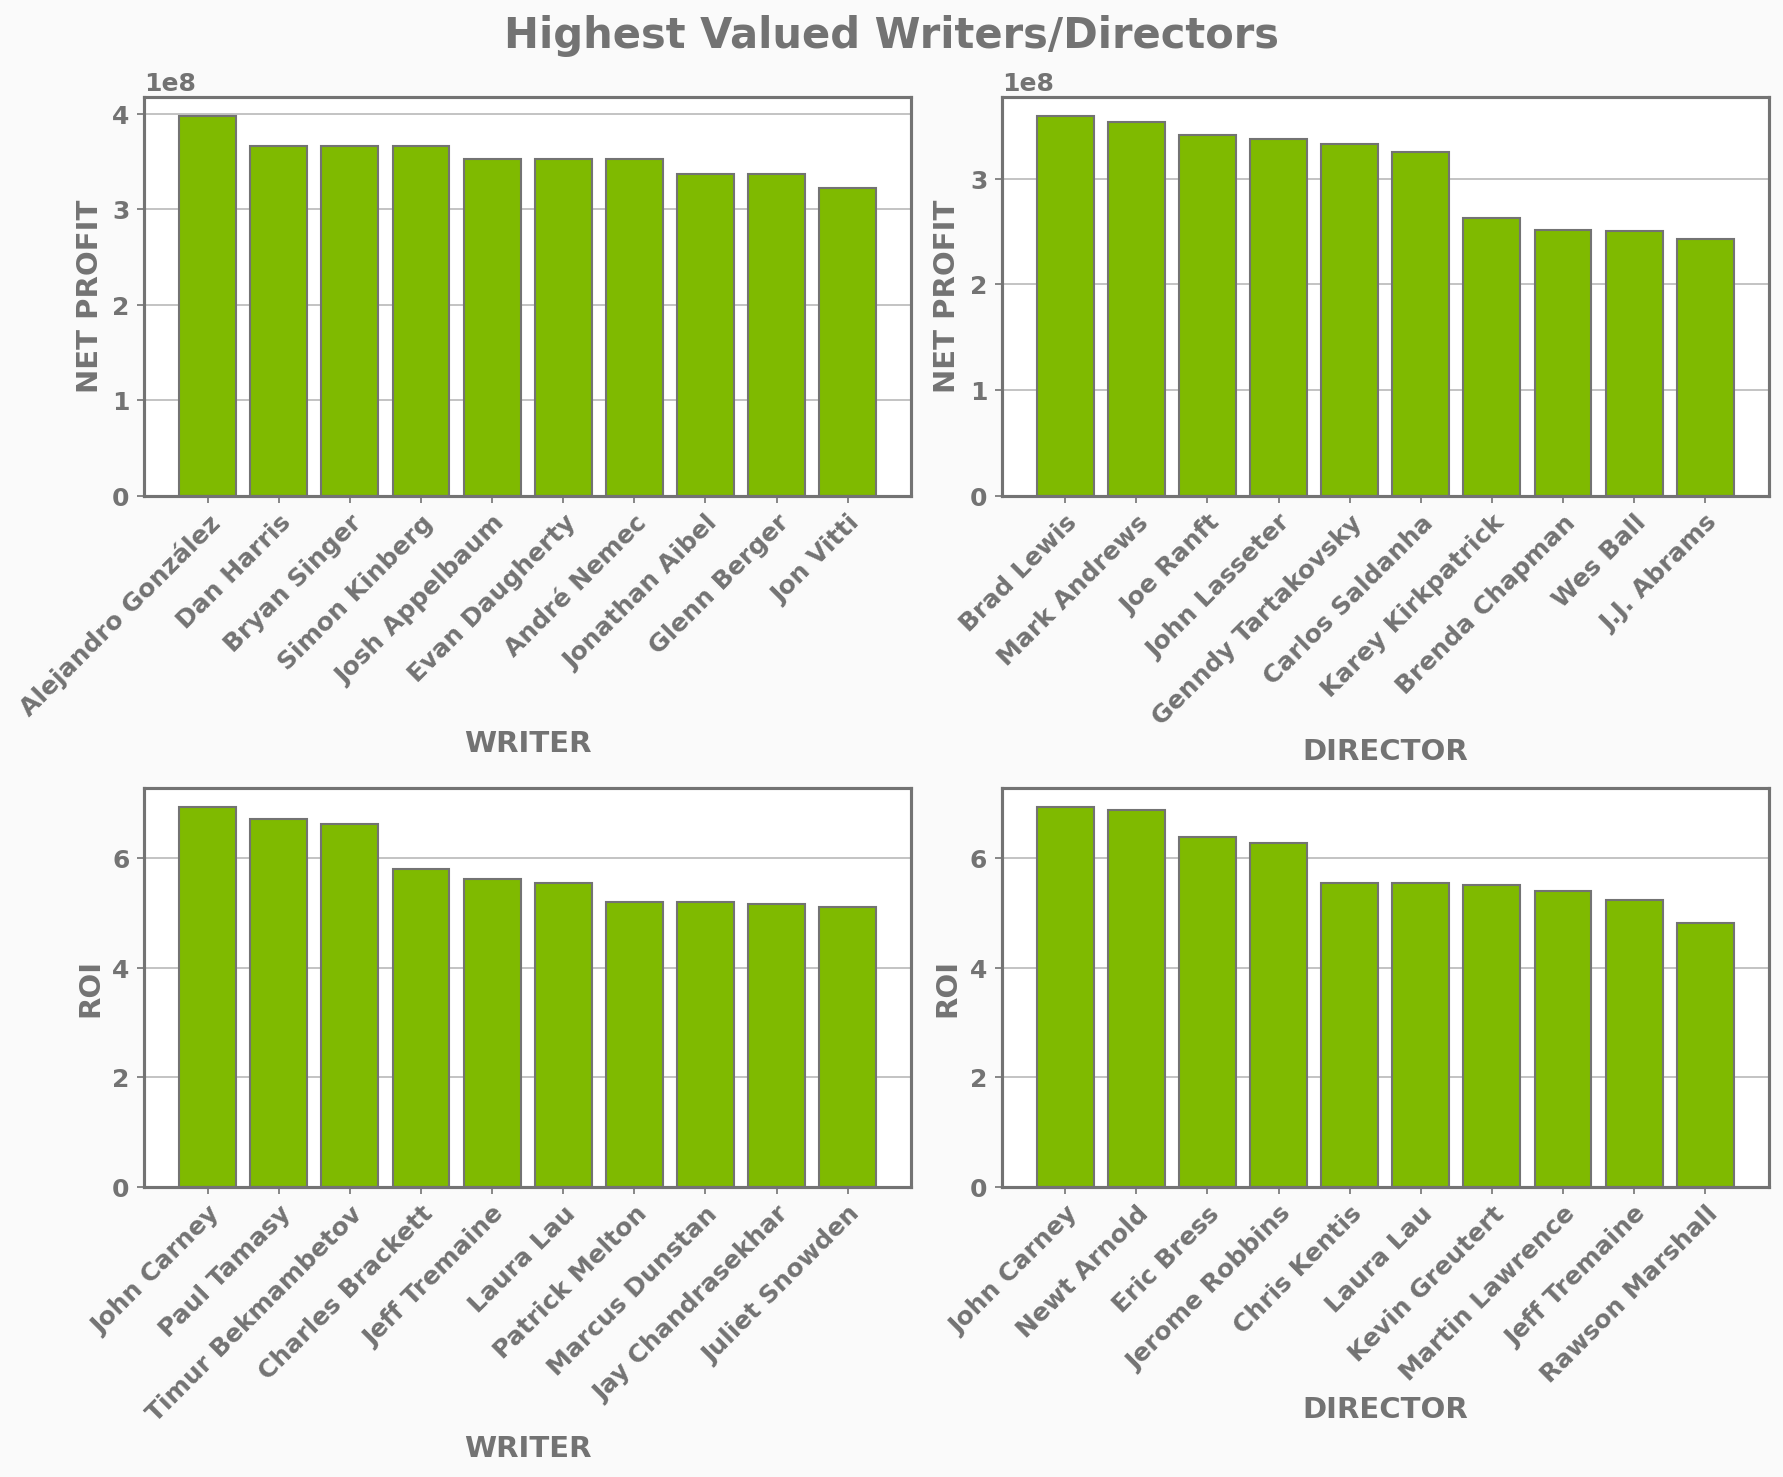

In [16]:
# DIRECTORS / WRITERS ANALYSIS
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(12,10))
fig.suptitle("Highest Valued Writers/Directors")

for idx, marker in enumerate(["net_profit", "ROI"]):
    for idx2, job in enumerate(["Writer", "Director"]):
        test = crew_df[crew_df.job == job]
        test = test.groupby("name").mean().sort_values(marker, ascending=False)[:10]

        ax = axs[idx][idx2]
        bars = ax.bar(test.index, height=test[marker])
        ax.set_xticks(ax.get_xticks()) # this prevents a warning caused by the following line.
        xticks = [" ".join(x.split(" ")[:2]) for x in test.index]
        ax.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode='anchor')
        ax.set_ylabel(marker.replace("_", " ").upper())
        ax.set_xlabel(job.upper())

## Top Directors by Top Genres
Finally, I wanted to find the top 3 directors for the top 2 genres by net profit and roi.  Using the for loop method got a little complex here with gettig the correct index, but I made a small alogrithm to solve them using the enumerations.

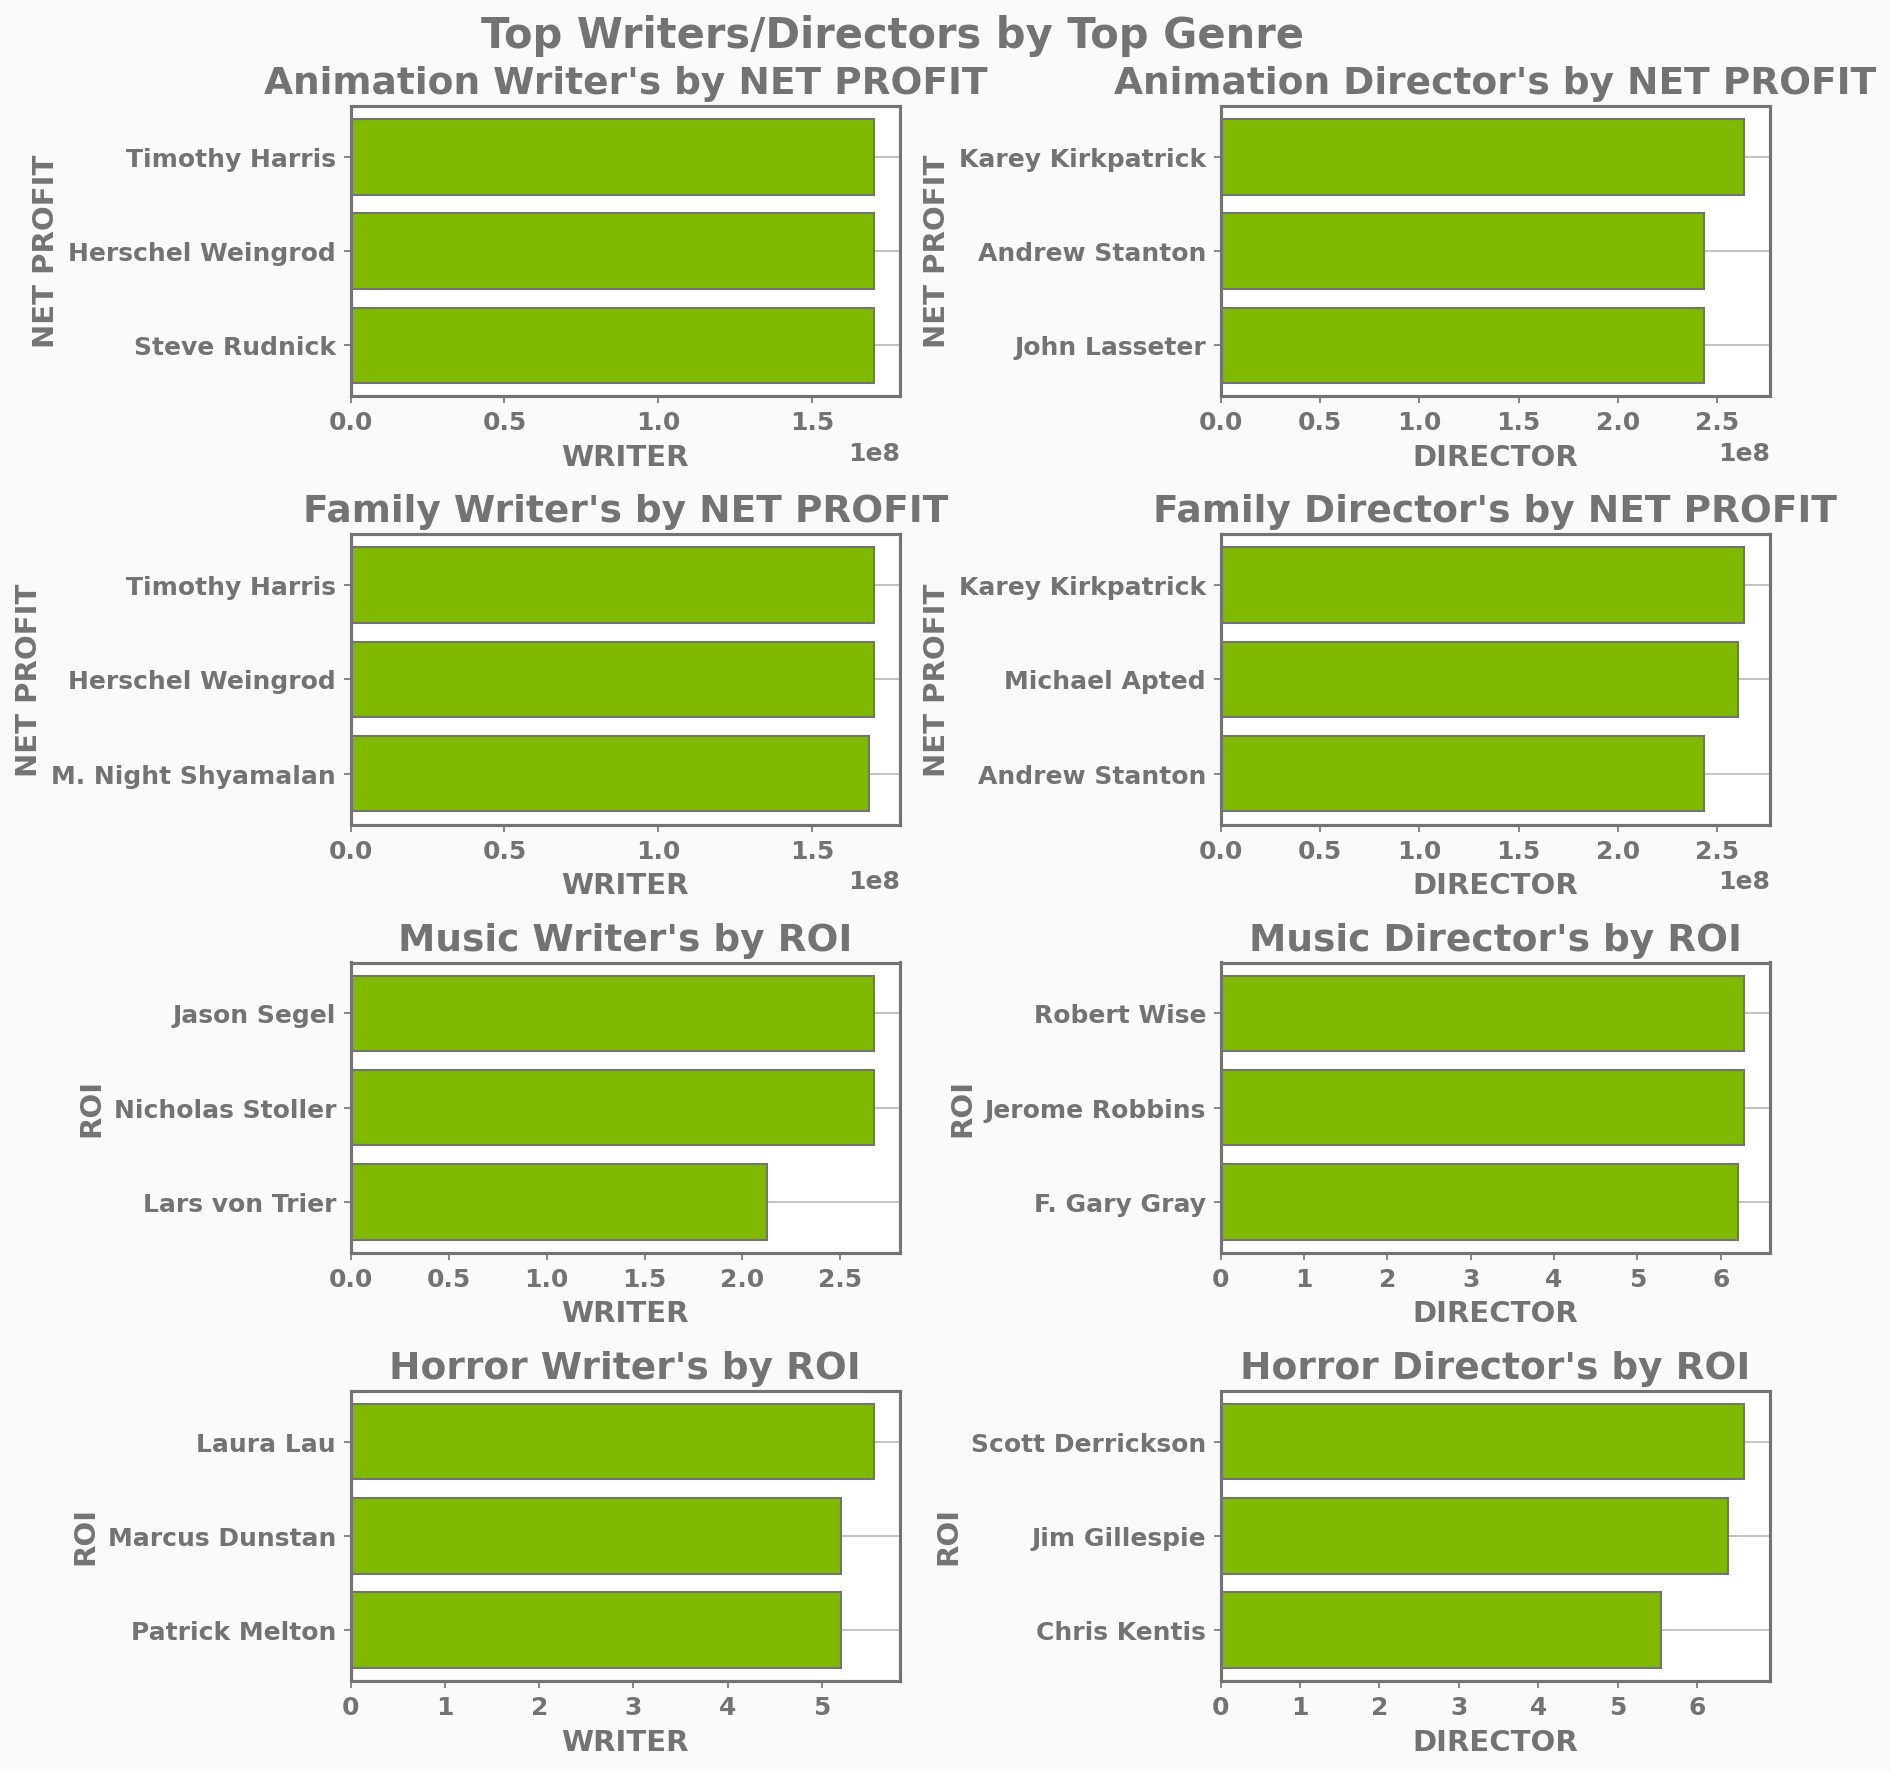

In [17]:
x = genres_df[["id", "genres"]].merge(crew_df[["id", "name", "job", "net_profit", "ROI"]], on="id")

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12,12))
fig.suptitle("Top Writers/Directors by Top Genre")
num = 2


for idx3, marker in enumerate(["net_profit", "ROI"]):
    for idx2, genre in enumerate(top_genres.get(marker)[:num]):
        for idx, job in enumerate(["Writer", "Director"]):
            y = x[x.job == job]

            y = y[["genres", "name", marker]].groupby(["genres", "name"]).mean()
            y = y.loc[genre].sort_values(marker, ascending=False)[:3]
            
            xticks = list(reversed(list(y.index)))
            ax = axs[idx2 + num * idx3][idx]
            marker_label = marker.replace("_", " ").upper()
            bars = ax.barh(xticks, width=y[marker].iloc[::-1])
            ax.set_title("%s %s's by %s" % (genre, job, marker_label))
            ax.set_ylabel(marker_label)
            ax.set_xlabel(job.upper())

# Conclusion and Discussion of Limitations

Using the information from the previous cell in conjunction with those prior, I am able to make reccomendations about 4 potential films that would be highly profitable.

#### To Maximize Net Profit
The top two genres by net profit are Animation and Family. Grouping the top Writers and Directors by these genres, two potential movies are:
1. An **Animated** film *written* by **Timothy Harris** and *directed* by **Karey Kirkpatrick**.
2. A **Family** film *written* by **Herschel Weingrod** and *directed* by **Michael Apted**.

#### To Maximize ROI
The top two genres by ROI are Music and Horror. Grouping the top Writers and Directors by these genres, two potential movies are:
1. A **Musical** film *written* by **Jason Segel** and *directed* by **Robert Wise**.
2. A **Horror** film *written* by **Laura Lau** and *directed* by **Scott Derrickson**.

## Limitations
Several limitations were proposed by the data used in this process. One would of course be the sample size. While 5000 is large enough to draw statistical conclusions, more is always better; particularly when making conclusions about individuals involved. With more samples, it is unlikely the genre analysis would have changed, but it is possible that the analysis of successful writers, directors, and actors would have been different. Secondly, this database did not have data corresponding to the rating of the films. From several other online analyses with similar goals, It would seem that rating may be an important marker correlating with profitability. Finally, it is important to note the inherent limitations of trying to predict public interest and approval. There may be several other variables at play, such as marketing or production company for example, that play significant roles in the success of a film that were not addressed here.
